# **Amazon Reviews Sentiment Analysis**

# *Method 1: TfIdf and Logistic Regression*

**Import libraries**

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
import re
import string
import time
import joblib
import bz2

**Function to extract text and labels**

In [7]:
# Get text and labels from raw file

def get_data(filepath):
    reviews = []
    text = []
    label = []
    with bz2.BZ2File(filepath,"r") as f:
        for line in f:
            x = line.decode()
            x = x.partition("_label__")
            reviews.append(x[2:])
        pass
    f.close()
    for review in reviews:
        label.append(review[0].split()[0])
        text.append(' '.join(review[0].split()[1:]))
        
    return text,label

**Function to create dataframe from extracted text and labels**

In [8]:
# Create dataframe

def create_dataframe(filepath):
    text,label = get_data(filepath)
    data = {"text":text,"label":label}
    df = pd.DataFrame(data)
    print("Number of records:",len(df))
    df.dropna(inplace=True) # remove null records
    df.reset_index(drop=True,inplace=True)
    df["label"] = df["label"].astype(int)
    print("Number of records after removing nulls:",len(df))
    
    return df

**Create train dataframe**

In [4]:
# Load train data

df = create_dataframe("/kaggle/input/amazonreviews/train.ft.txt.bz2")

# Change labels to 0 and 1
df['label'] = df['label'].apply(lambda x: 0 if x==1 else 1)

df.head()

Number of records: 3600000
Number of records after removing nulls: 3600000


,text,label
0,Stuning even for the non-gamer: This sound tra...,1
1,The best soundtrack ever to anything.: I'm rea...,1
2,Amazing!: This soundtrack is my favorite music...,1
3,Excellent Soundtrack: I truly like this soundt...,1
4,"Remember, Pull Your Jaw Off The Floor After He...",1


**Function to pre-process text**

In [5]:
# Preprocessing function

def preprocess_text(data):
    # convert to string
    data = str(data)
    # convert to lowercase
    data = data.lower()
    # remove special characters
    data = re.sub(r'[^\w ]+','',data)
    # remove links
    data = re.sub(r'(http|https)?://\S+|www\.\S+','',data)
    # remove non-ascii
    data = ''.join(word for word in data if ord(word) < 128)
    # remove punctuation
    data = data.translate(str.maketrans('','',string.punctuation))
    # remove digits
    data = re.sub(r'[\d]+','',data)
    # remove single letters
    data = ' '.join(word for word in data.split() if len(word)>1)
    # remove multiple spaces
    data = ' '.join(data.split())
    
    return data

**Apply the pre-process function on the text column**

In [6]:
# Apply preprocessing function to dataframe

df_copy = df.copy()
df_copy.loc[:,"text"] = df_copy["text"].apply(preprocess_text)
df_copy.head()

,text,label
0,stuning even for the nongamer this sound track...,1
1,the best soundtrack ever to anything im readin...,1
2,amazing this soundtrack is my favorite music o...,1
3,excellent soundtrack truly like this soundtrac...,1
4,remember pull your jaw off the floor after hea...,1


In [7]:
# Remove any null values post pre-processing
df_copy.dropna(inplace=True)
len(df_copy)

3600000

In [14]:
# Label counts
df_copy['label'].value_counts()

1    1800000
0    1800000
Name: label, dtype: int64

**Train/Dev split**

In [8]:
# Split into train and dev sets

df_train,df_dev = train_test_split(df_copy,
                                   test_size=0.2,
                                   stratify=df_copy["label"],
                                   random_state=42)

print("Train set size:",df_train.shape)
print("Dev set size:",df_dev.shape)

Train set size: (2880000, 2)
Dev set size: (720000, 2)


**Vectorize text using TfidfVectorizer**

In [9]:
# Fit TfidfVectorizer

tfidf = TfidfVectorizer()
train_tfidf = tfidf.fit_transform(df_train["text"])
dev_tfidf = tfidf.transform(df_dev["text"])

train_tfidf.shape,dev_tfidf.shape

((2880000, 1841815), (720000, 1841815))

**Training Logistic Regression model**

In [10]:
# Fit LogisticRegression model

labels = df_train['label']
lr = LogisticRegression(solver="lbfgs",max_iter=5000)
model_lr = lr.fit(train_tfidf,labels)

**Model predictions and metrics**

In [11]:
# Test model on dev set

predictions = model_lr.predict(dev_tfidf)

print("Accuracy for LR model:",accuracy_score(df_dev["label"],list(predictions)))

Accuracy for LR model: 0.9114333333333333


In [12]:
print("\t\tClassification Report:\n\n",classification_report(df_dev["label"],list(predictions)))

		Classification Report:

               precision    recall  f1-score   support

           0       0.91      0.91      0.91    360000
           1       0.91      0.91      0.91    360000

    accuracy                           0.91    720000
   macro avg       0.91      0.91      0.91    720000
weighted avg       0.91      0.91      0.91    720000



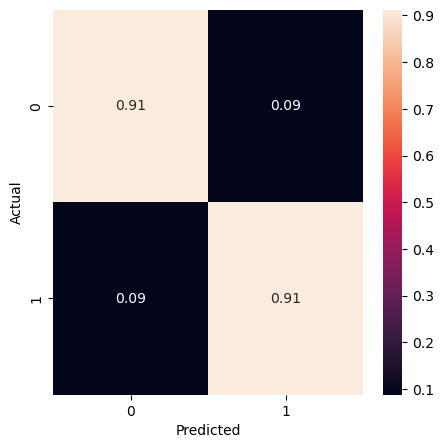

In [13]:
cm = confusion_matrix(df_dev["label"],list(predictions),normalize='true')
df_cm = pd.DataFrame(cm)
fig = plt.figure(figsize=(5,5))
ax = sns.heatmap(df_cm,annot=True,fmt='.2f')
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.show()

Accuracy from traditional NLP approach of Tfidf matrix conversion to vectors and training a Logistic Regression model is **0.91** with a f1 score of **0.91** for both the classes

# *Method 2: Transformers on a sample of data*

In [1]:
!pip install transformers==4.29.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 61.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.30.1
    Uninstalling transformers-4.30.1:
      Successfully uninstalled transformers-4.30.1


In [2]:
!pip install --upgrade accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 8.7 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.12.0
    Uninstalling accelerate-0.12.0:
      Successfully uninstalled accelerate-0.12.0


In [3]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 3.9 MB/s eta 0:00:00


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_auc_score,f1_score
from sklearn.model_selection import train_test_split
import torch
from transformers import pipeline
import evaluate
from datasets import load_dataset

**Load dataset**

In [10]:
# Load train data

df = create_dataframe("/kaggle/input/amazonreviews/train.ft.txt.bz2")

# Change labels to 0 and 1
df['label'] = df['label'].apply(lambda x: 0 if x==1 else 1)
df.head()

Number of records: 3600000
Number of records after removing nulls: 3600000


,text,label
0,Stuning even for the non-gamer: This sound tra...,1
1,The best soundtrack ever to anything.: I'm rea...,1
2,Amazing!: This soundtrack is my favorite music...,1
3,Excellent Soundtrack: I truly like this soundt...,1
4,"Remember, Pull Your Jaw Off The Floor After He...",1


**Select a sample of data (n = 100,000)**

In [11]:
# Selecting a sample of the data to avoid GPU memory issues
df_final = df.sample(100000,ignore_index=True)
df_final.head()

,text,label
0,Excellent: Excellent book for people who works...,1
1,Fails to tackle the issues.: We read this in o...,0
2,"ronnie's solo stuff was never any good,: He wa...",0
3,Very Nice Choice For Younger Boys: I have two ...,1
4,"Cute, cute, cute.: If you go in for those cute...",1


**Save file and convert dataset format for transformers**

In [12]:
# Save to file
df_final.to_csv('df_final.csv',index=None)

# Convert dataset format
raw_dataset = load_dataset("csv",data_files="df_final.csv")
raw_dataset

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/datasets/packaged_modules/csv/csv.py:154: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  csv_file_reader = pd.read_csv(file, iterator=True, dtype=dtype, **self.config.read_csv_kwargs)


Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-8136c01fc844e362/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 100000
    })
})

**Split into train and test**

In [13]:
# Split raw dataset into train and test

split = raw_dataset['train'].train_test_split(train_size=0.8,seed=42)
split

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 80000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 20000
    })
})

**Define Tokenizer**

In [14]:
# Tokenizer
checkpoint = "distilbert-base-cased"
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

**Function for tokenizing**

In [15]:
def tokenize_fn(batch):
    return tokenizer(batch['text'],truncation=True)

**Tokenize dataset**

In [16]:
tokenized_dataset = split.map(tokenize_fn)
tokenized_dataset

  0%|          | 0/80000 [00:00<?, ?ex/s]

  0%|          | 0/20000 [00:00<?, ?ex/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 80000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 20000
    })
})

**Dynamic Padding to equalize sequence lengths**

In [17]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

**Post Processing**

In [18]:
# Remove the columns corresponding to values the model does not expect (like the sentence1 and sentence2 columns).
# Rename the column label to labels (because the model expects the argument to be named labels).
# Set the format of the datasets so they return PyTorch tensors instead of lists.

tokenized_dataset = tokenized_dataset.remove_columns(['text'])
tokenized_dataset = tokenized_dataset.rename_column("label","labels")
tokenized_dataset.set_format("torch")
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 80000
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 20000
    })
})

**Define Dataloaders**

In [19]:
# Define dataloaders

from torch.utils.data import DataLoader

train_dataloader = DataLoader(tokenized_dataset['train'],batch_size=10,shuffle=True,collate_fn=data_collator)
eval_dataloader = DataLoader(tokenized_dataset['test'],batch_size=10,shuffle=True,collate_fn=data_collator)

In [20]:
# check
for batch in train_dataloader:
    break
{k:v.shape for k,v in batch.items()}

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'labels': torch.Size([10]),
 'input_ids': torch.Size([10, 217]),
 'attention_mask': torch.Size([10, 217])}

**Define Model**

In [21]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint,num_labels=2)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.wei

In [22]:
# summary
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           1,538
├─Dropout: 1-4                                          --
Total params: 65,783,042
Trainable params: 65,783,042
Non-trainable params: 0

**Optimizer and Learning Rate**

In [23]:
# Optimizer and learning rate

from transformers import AdamW

optimizer = AdamW(model.parameters(),lr=5e-5)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


**Learning Rate Scheduler**

In [24]:
# Learning Rate Scheduler

from transformers import get_scheduler

num_epochs = 2
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
print(num_training_steps)

16000


In [25]:
# GPU

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
device

device(type='cuda')

**Clearing GPU memory**

In [26]:
import gc
gc.collect()
torch.cuda.empty_cache()

**Model Training**

In [27]:
# Model Training

from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/16000 [00:00<?, ?it/s]

**Evaluation**

In [28]:
# Evaluation

metric = evaluate.combine(["accuracy","f1"])

model.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute()

{'accuracy': 0.95015, 'f1': 0.9503213912003589}

Although the transformers model was run on a very small sample due to memory issues, an accuracy and f1 score of around **0.95** shows that transformers perform much better than traditional NLP models